<a class="anchor" id="0"></a>

# **ARIMA Model for Time Series Forecasting: COVID-19 Confirmed Cases in Canada**

# Importing Packages and Dataset <a class="anchor" id="1"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
import statsmodels.api as sm
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams


- Now, we will import the CSV file from a Url and show the top 5 rows of the dataset.

In [2]:
df = pd.read_csv (r'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv',parse_dates=True)
print ('Shape of data', df.shape)
df.head()

Shape of data (10992, 40)


,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


- Removing blank cells to ensure dataset is not negatively affected by Nulls and NaN cells.

In [3]:
df.isnull().sum()

pruid                     0
prname                    0
prnameFR                  0
date                      0
update                 5272
numconf                   0
numprob                4680
numdeaths               119
numtotal                  0
numtested              6087
numtests                  0
numrecover              524
percentrecover          728
ratetested             6426
ratetests               802
numtoday                  0
percentoday               0
ratetotal               729
ratedeaths              729
numdeathstoday          119
percentdeath            397
numtestedtoday         6087
numteststoday            72
numrecoveredtoday       524
percentactive           397
numactive               397
rateactive              729
numtotal_last14         252
ratetotal_last14        968
numdeaths_last14        252
ratedeaths_last14       968
numtotal_last7          252
ratetotal_last7         968
numdeaths_last7         252
ratedeaths_last7        969
avgtotal_last7      

In [4]:
df.dropna(inplace = True)

C:\Users\prude\AppData\Local\Temp\ipykernel_35384\820435583.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


- Correlation of each column to one another

In [5]:
df.corr()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
pruid,1.000000,-0.046805,-0.283051,-0.037165,-0.352297,-0.283053,-0.192874,-0.317853,-0.278540,0.123471,...,0.019152,-0.209513,0.059922,-0.283794,0.017877,-0.209512,0.059924,-0.283373,0.017842,0.040549
update,-0.046805,1.000000,0.053300,-0.004665,0.067242,0.053300,0.018843,0.063479,0.053657,-0.029874,...,0.068841,0.043984,0.006964,0.050576,0.070742,0.043986,0.006964,0.050512,0.070626,0.142966
numconf,-0.283051,0.053300,1.000000,-0.003722,0.931857,1.000000,0.139758,0.976488,0.995500,0.101145,...,0.157570,0.678783,0.104361,0.517238,0.144367,0.678782,0.104359,0.517387,0.144540,0.079605
numprob,-0.037165,-0.004665,-0.003722,1.000000,-0.000795,-0.003687,-0.008701,-0.005250,0.004111,-0.023641,...,-0.006624,0.000154,-0.002845,0.023721,-0.005969,0.000155,-0.002848,0.023931,-0.005732,-0.004427
numdeaths,-0.352297,0.067242,0.931857,-0.000795,1.000000,0.931858,0.280259,0.963082,0.927150,0.071011,...,0.168307,0.608905,0.055157,0.560859,0.151154,0.608906,0.055155,0.561021,0.151264,0.045248
numtotal,-0.283053,0.053300,1.000000,-0.003687,0.931858,1.000000,0.139758,0.976488,0.995500,0.101144,...,0.157570,0.678783,0.104361,0.517239,0.144367,0.678783,0.104359,0.517388,0.144541,0.079605
numtested,-0.192874,0.018843,0.139758,-0.008701,0.280259,0.139758,1.000000,0.208348,0.118128,-0.016865,...,0.194310,0.247387,0.053911,0.499712,0.187906,0.247388,0.053911,0.499832,0.188172,0.038399
numtests,-0.317853,0.063479,0.976488,-0.005250,0.963082,0.976488,0.208348,1.000000,0.973196,0.106898,...,0.121080,0.650050,0.077979,0.500232,0.111410,0.650049,0.077976,0.500353,0.111575,0.057994
numrecover,-0.278540,0.053657,0.995500,0.004111,0.927150,0.995500,0.118128,0.973196,1.000000,0.111948,...,0.144835,0.645431,0.090195,0.499668,0.131921,0.645431,0.090193,0.499821,0.132079,0.069345
percentrecover,0.123471,-0.029874,0.101145,-0.023641,0.071011,0.101144,-0.016865,0.106898,0.111948,1.000000,...,-0.271004,-0.027631,-0.161365,-0.219493,-0.276001,-0.027632,-0.161366,-0.219029,-0.275954,-0.058325


- Preparing model

In [6]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression and Critical Value Calculation :",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

- Determining if the p-value is greater than the significance level (0.05).

In [7]:
ad_test(df['numconf'])

1. ADF :  1.1382204265382956
2. P-Value :  0.9955299736654541
3. Num Of Lags :  39
4. Num Of Observations Used For ADF Regression and Critical Value Calculation : 10952
5. Critical Values :
	 1% :  -3.4309472272964143
	 5% :  -2.861803941465474
	 10% :  -2.566910490913334


- Data visualization

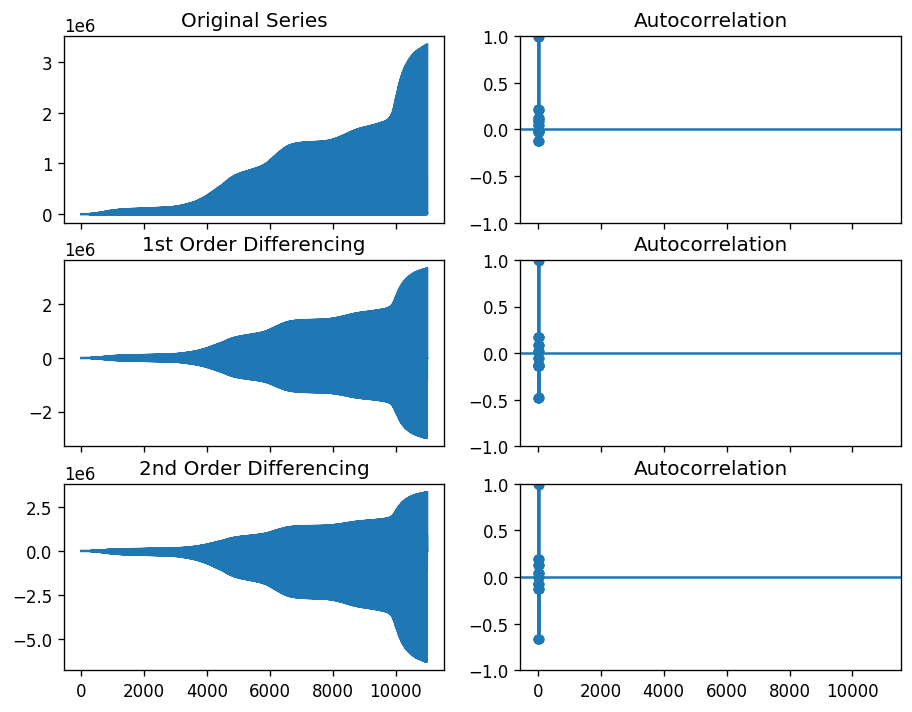

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.numconf); axes[0, 0].set_title('Original Series')
plot_acf(df.numconf, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.numconf.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.numconf.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.numconf.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.numconf.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

- Figure Out Order for ARIMA Model.

In [14]:
from pmdarima.arima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

- Enter the variable in the ' ' below that will be forecasted.

In [15]:
stepwise_fit = auto_arima(df['numconf'], trace=True,
                          suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=319267.238, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=316415.808, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=319265.242, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=315603.777, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=315022.202, Time=0.48 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=313327.463, Time=0.61 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=312906.483, Time=0.72 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=311111.394, Time=5.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=311258.320, Time=3.98 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.00 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.93 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=5.26 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10992
Model:               SARIMAX(5, 1, 1)   Log Likelihood             -155547.697
Date:                Thu, 10 Mar 2022   AIC                         311111.394
Time:                        22:05:47   BIC                         311169.833
Sample:                             0   HQIC                        311131.083
                              - 10992                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    305.4287    123.860      2.466      0.014      62.667     548.190
ar.L1         -0.0434      0.026     -1.653      0.098      -0.095       0.008
ar.L2         -0.0639      0.025     -2.586      0.010      -0.112      -0.015
ar.L3         -0.1554      0.031     -4.948      0.000      -0.217      -0.094
ar.L4         -0.1561      0.025     -6.184      0.000      -0.206      -0.107
ar.L5          0.0910      0.013      6.756      0.000       0.065       0.117
ma.L1         -0.9893      0.004   -255.448      0.000      -0.997      -0.982
sigma2      1.353e+11   1.24e-07   1.09e+18      0.000    1.35e+11    1.35e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            280554.50
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             166.89   Skew:                             3.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+36. Standard errors may be unstable.
"""

In [16]:
from statsmodels.tsa.arima_model import ARIMA

- Split Data into Training and Testing.

In [17]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(10992, 40)
(10962, 40) (30, 40)


- Train the Model.

In [18]:
model=ARIMA(train['numconf'],order=(5,1,1))
model=model.fit()
model.summary()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


- Make Predictions on Test Set.

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
print(pred)
#pred.index=df.index[start:end+1]
#print(pred)

In [ ]:
pred.plot(legend=True)
test[''].plot(legend=True)

In [ ]:
test[''].mean()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['']))
print(rmse)

In [ ]:
model2=ARIMA(df['Confirmed Positive'],order=(1,0,5))
model2=model2.fit()
df.tail()

- For Future Dates.

In [ ]:
index_future_dates=pd.date_range(starts='',end='')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
#print(comp_pred)

In [ ]:
pred.plot(figsize=(12,5),legend=True)